<a href="https://colab.research.google.com/github/thejarlid/makemore/blob/main/micrograd/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Micrograd is an autograd engine that implements backprop. Which allows you to
efficiently calculate the gradients of a neural network with a PyTorch-like
API. This DAG only operates on scalars rather than on tensors.
"""

'\nMicrograd is an autograd engine that implements backprop. Which allows you to\nefficiently calculate the gradients of a neural network with a PyTorch-like\nAPI. This DAG only operates on scalars rather than on tensors. \n'

In [ ]:
# Below is a brief review of Derivatives

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [ ]:
f(3.0)

20.0

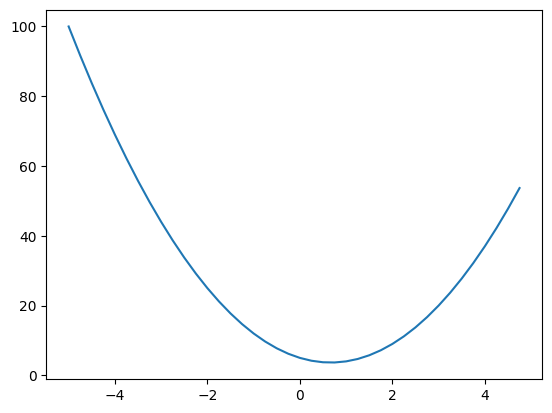

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys
plt.plot(xs, ys)

In [ ]:
h = 0.00000000000001
x = -3.0
m = (f(x + h) - f(x))/h
print(m)

x = 3.0
m = (f(x + h) - f(x))/h
print(m)

x = 2/3
m = (f(x + h) - f(x))/h
print(m)

-22.026824808563106
14.210854715202004
0.0


In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    # internal variables used for autograd graph construction
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, (self, other), '+')

      def _backward():
          self.grad += out.grad
          other.grad += out.grad
      out._backward = _backward

      return out

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward

      return out

  def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
          self.grad += (other * self.data**(other-1)) * out.grad
      out._backward = _backward

      return out

  def __neg__(self): # -self
      return self * -1

  def __radd__(self, other): # other + self
      return self + other

  def __sub__(self, other): # self - other
      return self + (-other)

  def __rsub__(self, other): # other - self
      return other + (-self)

  def __rmul__(self, other): # other * self
      return self * other

  def __truediv__(self, other): # self / other
      return self * other**-1

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

      # topological order all of the children in the graph
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
      build_topo(self)

      # go one variable at a time and apply the chain rule to get its gradient
      self.grad = 1
      for v in reversed(topo):
          v._backward()


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))

    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

In [ ]:
def lol():

  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)
lol()

0.0


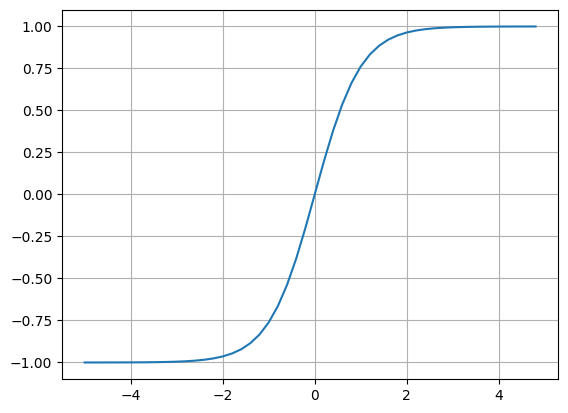

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

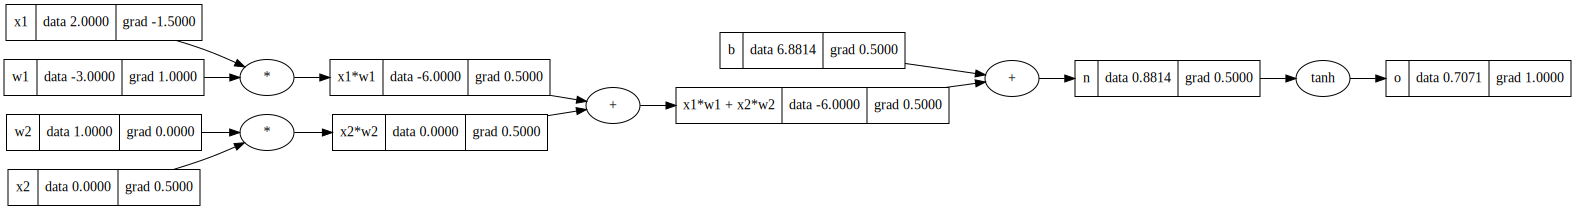

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---
o = n.tanh()
# ---
o.label = 'o'

o.backward()
draw_dot(o)

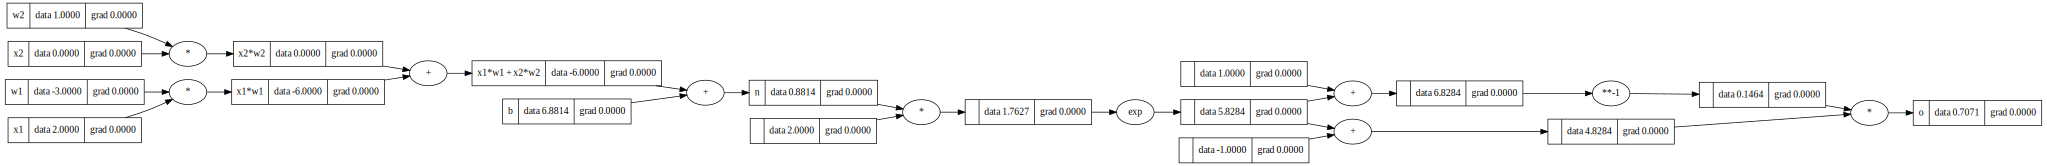

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---

o.label = 'o'
draw_dot(o)

In [ ]:
import random

class Neuron:
  def __init__(self, nin) -> None:
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout) -> None:
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts) -> None:
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5567914563795668)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(30):
  # forward pass
  ypred = [n(x) for x in xs]

  # mean squared error loss
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backwards pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 2.985507909263279
1 2.0328107661215373
2 1.1826497489433285
3 0.7076163918717385
4 0.4573818170939615
5 0.32053522084447167
6 0.24024485945403462
7 0.1893236193292673
8 0.15481897802050493
9 0.13017456231306707
10 0.111825952836281
11 0.09770465298381772
12 0.08654135255259815
13 0.07751967594614756
14 0.07009336732128768
15 0.063884453369382
16 0.0586238030739958
17 0.054114996979162756
18 0.050211574755327025
19 0.04680225692090591
20 0.0438010807009126
21 0.041140655033425684
22 0.0387674481322575
23 0.03663843106353517
24 0.034718645315908375
25 0.032979412123726265
26 0.03139699530415943
27 0.02995158968100265
28 0.028626546650752305
29 0.027407774774316898


In [ ]:
ypred

[Value(data=0.9097134235156398),
 Value(data=-0.9082720331384966),
 Value(data=-0.9406472750954528),
 Value(data=0.9144468409530616)]